In [1]:
import pandas as pd
import os 
import shutil 
import numpy as np
import re

from htbam_analysis.processing import chip
from htbam_analysis.processing import experiment as exp
from htbam_analysis.processing import chipcollections as collections
from pathlib import Path 

from matplotlib import pyplot as plt

# 20250507 Processing Testing Notebook

Eventually want to migrate this to a script to run manually. All testing data is from Jacob's competitive binding experiment and can be found [here](https://ucsf.app.box.com/folder/319917416835?s=akbyjn6glvzxe574j7cnfp71afa7gh26).

In [2]:
root = '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive'
description = 'Cycling'
operator = 'JSZ'
setup_num = 's1'
device_num = 'd3'
device_dimensions = (32, 56)
e = exp.Experiment(description, root, operator)

pinlist = e.read_pinlist('/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/20230208_pinlist.csv')

INFO     Experiment Initialized | Description: Cycling, Operator: JSZ


## Generation of reference devices

I suspect that some of the slight discrepancies between the processing output here and the test data can be attributed to differences in corner picking and processing. From the look of it, no reference images were generated for the binding (i.e. button finding applied to all images).

In [3]:
# utility function for making a reference chip

def make_reference_chip(
        reference_image: str, 
        channel: str,
        exposure: int,
        corners: tuple, 
        feature: str,
        coerce_center: bool,
        pinlist,
        setup_num, 
        device_num, 
        device_dimensions,
        ):

    device = exp.Device(setup_num, device_num, device_dimensions, pinlist, corners)
    reference = collections.ChipQuant(device, 'Chamber_Ref')
    reference.load_file(reference_image, channel, exposure)

    if feature == 'chamber':
        reference.process(mapped_features = 'chamber', coerce_center = coerce_center)
        reference.save_summary_image(feature_type = 'chamber')
    else:
        reference.process(coerce_center = coerce_center)
        reference.save_summary_image()

    return device, reference

In [4]:
# one reference device for all conditions except for 333µM ADPR
binding1_corners = ((447, 381), (6722, 466), (359, 6759), (6633, 6840))
binding1_device, binding1_reference = make_reference_chip(
    '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250206-223546-d3_0_ADPR_100AF_PostWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif',
    '3',
    '5',
    binding1_corners,
    'button',
    False,
    pinlist,
    setup_num,
    device_num,
    device_dimensions    
)

Finding Buttons: 100%|██████████| 1792/1792 [02:20<00:00, 12.79it/s]


In [5]:
# separate reference image for condition with 333µM ADPR
binding2_corners = ((410, 435), (6686, 527), (311, 6811), (6587, 6900))
binding2_device, binding2_reference = make_reference_chip(
    '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch2/20250207-021205-d3_333_ADPR_100AF_PostWash_Quant/3/StitchedImages/BGSubtracted_StitchedImg_5_3_0.tif',
    '3',
    '5',
    binding2_corners,
    'button',
    False,
    pinlist,
    setup_num,
    device_num,
    device_dimensions    
)

Finding Buttons: 100%|██████████| 1792/1792 [02:48<00:00, 10.64it/s]


## Binding processing

Using a new ButtonBindingSeries object

In [6]:
binding_path = '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding'
bait_channel, bait_exposure = '2', 5
prey_channel, prey_exposure = '3', 5


binding_processor_batch1 = collections.ButtonBindingSeries(
    device=binding1_device, 
    button_ref=binding1_reference, 
    prey_channel=prey_channel,
    prey_exposure=prey_exposure,
    bait_channel=bait_channel,
    bait_exposure=bait_exposure
    )
binding_processor_batch2 = collections.ButtonBindingSeries(
    device=binding1_device, 
    button_ref=binding2_reference, 
    prey_channel=prey_channel,
    prey_exposure=prey_exposure,
    bait_channel=bait_channel,
    bait_exposure=bait_exposure
    )


binding_processor_batch1.grab_binding_images('/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1', verbose=True)
binding_processor_batch2.grab_binding_images('/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch2', verbose=True)

PREWASH BAIT IMAGES:
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250207-014708-d3_111_ADPR_100AF_PreWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250207-013406-d3_12_ADPR_100AF_PreWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250206-233109-d3_1000_ADPR_100AF_PreWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250207-012104-d3_1_3_ADPR_100AF_PreWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250207-011434-d3_0_4_ADPR_100AF_PreWash_Quant/2/StitchedImages/BGSubtracted_StitchedImg_5_2_0.tif
/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1/20250207-014037-d3_37_A

In [7]:
def concentration_from_note_batch1(file):

    parent_path = '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch1'

    # use regex to pull out note
    handle = os.path.relpath(file, parent_path).split('/')[0]
    note_match = re.search(r"\d{8}-\d{6}-d\d+_(.+?)_(PreWash|PostWash)_Quant", handle)
    if note_match:
        note = note_match.group(1)
    else:
        pass

    concentration = float(note.split('_ADPR_100AF')[0].replace('_', '.'))
    return concentration

def concentration_from_note_batch2(file):

    parent_path = '/Users/jonathanzhang/Downloads/binding_mpro_adpr-competitive/Binding/batch2'

    # use regex to pull out note
    handle = os.path.relpath(file, parent_path).split('/')[0]
    note_match = re.search(r"\d{8}-\d{6}-d\d+_(.+?)_(PreWash|PostWash)_Quant", handle)
    if note_match:
        note = note_match.group(1)
    else:
        pass

    concentration = float(note.split('_ADPR_100AF')[0].replace('_', '.'))
    return concentration


In [8]:
binding_processor_batch1.process(concentration_parser=concentration_from_note_batch1)

Processing Pre-Wash Bait Images...


100%|██████████| 9/9 [00:43<00:00,  4.82s/it]


Processing Post-Wash Bait Images...


100%|██████████| 9/9 [00:42<00:00,  4.74s/it]


Processing Post-Wash Prey Images...


100%|██████████| 9/9 [00:40<00:00,  4.52s/it]


In [9]:
binding_processor_batch2.process(concentration_parser=concentration_from_note_batch2)

Processing Pre-Wash Bait Images...


100%|██████████| 1/1 [00:04<00:00,  4.42s/it]


Processing Post-Wash Bait Images...


100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


Processing Post-Wash Prey Images...


100%|██████████| 1/1 [00:04<00:00,  4.51s/it]


## Comparison of new data against test

Distributions of differences between button fluorescence between experiments is centered at zero. Some outliers. Not sure how significant this is, given that the raw data was likely processed differently. For instance, different corners may have been picked, and more importantly, it appears that the test data was generated without the usage of any reference images. 

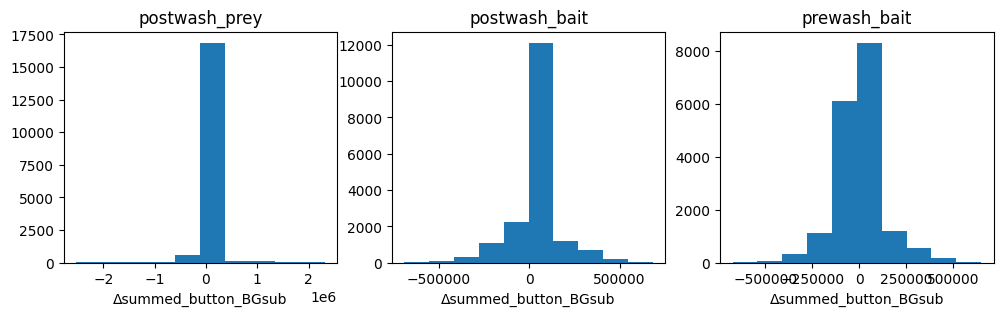

In [11]:
image_type = ['postwash_prey', 'postwash_bait', 'prewash_bait']
test_data = [
    pd.read_csv('./test_data/competitive_binding_mpro_adpr/postwash_prey.csv.bz2'),
    pd.read_csv('./test_data/competitive_binding_mpro_adpr/postwash_bait.csv.bz2'),
    pd.read_csv('./test_data/competitive_binding_mpro_adpr/prewash_bait.csv.bz2')
]
for d in test_data:
    d.sort_values(by=['x', 'y', 'time_s'], inplace=True)

new_data = [
    pd.concat([binding_processor_batch1.postwash_prey_data, binding_processor_batch2.postwash_prey_data]),
    pd.concat([binding_processor_batch1.postwash_bait_data, binding_processor_batch2.postwash_bait_data]),
    pd.concat([binding_processor_batch1.prewash_bait_data, binding_processor_batch2.prewash_bait_data])
]

fig, axs = plt.subplots(ncols=3, figsize=(12,3))
differences = []
for i in range(len(test_data)):
    difference = test_data[i]['summed_button_BGsub'].to_numpy() - new_data[i]['summed_button_BGsub'].to_numpy()
    differences.append(difference)
    axs[i].hist(difference)
    axs[i].set_title(image_type[i])
    axs[i].set_xlabel('Δsummed_button_BGsub')